<a href="https://colab.research.google.com/github/ed-roberts-github/Valerran/blob/main/Task1_Valerran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Valerran Interview - Ed Roberts
## Task 1: Geometry Snapping

### Part One: LRS to WGS
Outline of method:

The main issue is that our LRS coordinate system has a different projection compared with WGS; basically the distance between two points in WGS is not given in meters. I will therefore have to convert to another CRS, in particular EPSG:27700, so that distances can be measured in meters. I will then calculate points at certain distance along the linestring in this CRS, then convert back to the original WGS to find the coordinates required. As the document suggests, I am ignoring the y coordinate in the LRS so really only have to calculate the x coordinate (distance travelled from east most point).

- First, I will load in the data and perform a few checks to ensure it is setup correctly (i.e. plot the linestring)

- Next, I will convert the linestring into EPSG:27700 so that distances can be measured in meters. I check this is done correctly by comparing the total length of the linestring to the total length given in the document.

- I will then use the interpolate method to calculate the distance traversed along the line. It is important to note here, the document provided defines LRS to have an origin at the east-most point and the given Linestring is defined from west to east. I fix this by simply interpolating the distance as (total_length - lrs_x). Alternatively, I could reverse the order of the Linestring. It is nice we have no 'loops' in the linestring which could cause issues in determining the east most point.

- I pass the interpolated point into a GeoDataFrame initially with crs = 'EPSG:27700'.

- The final step is to simply convert this point back to crs = 'EPSG:4326' and plot to ensure my result looks correct


In [1]:
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

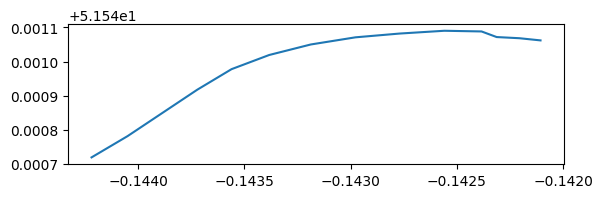

In [2]:
wkt_linestring = 'LINESTRING(-0.1421021 51.5410616,-0.1422064 51.5410683,-0.1423133 \
                  51.5410717,-0.1423844 51.5410881,-0.1425594 51.5410901,-0.1427707 \
                  51.5410819,-0.1429775 51.5410709,-0.1431874 51.54105,-0.1433833 \
                  51.5410192,-0.1435602 51.5409778,-0.1437212 51.5409178,-0.1440496 \
                  51.5407818,-0.1440836 51.5407693,-0.1442231 51.5407181)'

gdf = gpd.GeoDataFrame(geometry=[loads(wkt_linestring)], crs='EPSG:4326')
gdf.plot();

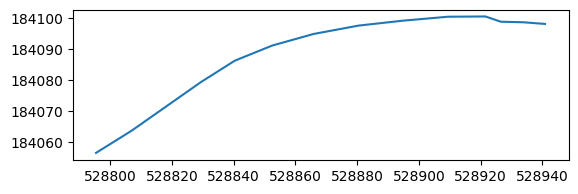

In [3]:
gdfm = gdf.to_crs(crs='EPSG:27700')
gdfm.plot();

In [4]:
gdfm.length[0]

157.36859375630212

Great! This matches the length given in the document so looks like I've managed to transform into a CRS which has units of meters. Now onto actually doing part one.

In [5]:
def lrs_to_wgs(lrs_distance, gdf_wgs):
  # First convert from wgs to a crs which measures distance in meters
  gdf_meters =  gdf_wgs.to_crs(crs='EPSG:27700')

  # Calculate the position of the point in the meters crs
  point_meters = gpd.GeoDataFrame(geometry = [gdf_meters.iloc[0,0].interpolate(
                                              gdf_meters.length[0]-lrs_distance)],
                                  crs = 'EPSG:27700')

  # Covert the point back to the WGS geometry
  point_wgs = point_meters.to_crs(crs='EPSG:4326')

  return point_wgs


def plot_point_line(point, line, crs):
  geom = [line['geometry'].iloc[0]] + [point['geometry'].iloc[0]]
  gdf2 = gpd.GeoDataFrame(geometry=geom, crs = crs)
  gdf2.plot()


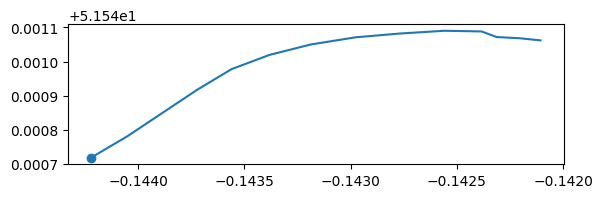

In [6]:
lrs_x_distance = 0
point1 = lrs_to_wgs(lrs_x_distance, gdf)
plot_point_line(point1, gdf, 'EPSG:4326')

In [7]:
point1

,geometry
0,POINT (-0.14422 51.54072)


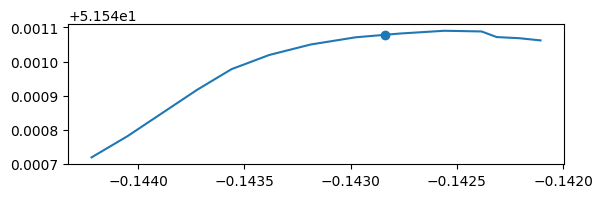

In [8]:
lrs_x_distance = 106
point2 = lrs_to_wgs(lrs_x_distance, gdf)
plot_point_line(point2, gdf, 'EPSG:4326')

In [9]:
point2

,geometry
0,POINT (-0.14284 51.54108)


### Part One: Answers


(0 0) -> (-0.1442231 51.5407181)

(106 0) -> (-0.1428365 51.5410784)

Origin is as expected by definition!

-----

### Part two: WGS to LRS

My method here is essentially the reverse of my method in part one so I will save writing all the details. I am still projecting between different CRS (WRS to meters projects).

The key difference is I am using the 'project' method to calculate how far along the linestring the point is. This distance is then easily converted into the LRS corrdinates.


In [10]:
def wgs_to_lrs(wkt_point, gdf_wgs):
  # Initialising the point in wgs
  target_point = gpd.GeoDataFrame(geometry=[wkt_point], crs='EPSG:4326')

  # Converting point and line to meters space
  target_point_meters = target_point.to_crs(crs= 'EPSG:27700')
  gdf_m = gdf_wgs.to_crs(crs='EPSG:27700')

  # Calculating x coord of lrs
  LRS_x = gdf_m.length - gdf_m['geometry'].project(target_point_meters['geometry'].iloc[0])

  return Point(round(LRS_x.iloc[0],7), 0)

def plot_wgs(gdf_wgs, target_point):
  target_point_wgs = gpd.GeoDataFrame(geometry=[target_point], crs='EPSG:4326')
  geom = [gdf_wgs['geometry'].iloc[0]] + [target_point_wgs['geometry'].iloc[0]]
  gdf2 = gpd.GeoDataFrame(geometry=geom, crs = 'EPSG:4326')
  gdf2.plot()


POINT (110.5852393 0)


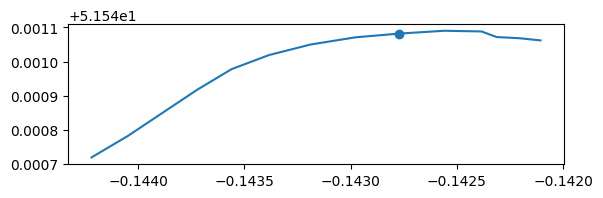

In [11]:
point_1 = Point(-0.1427707, 51.5410819)
lrs_x_coords_1 = wgs_to_lrs(point_1, gdf)
print(lrs_x_coords_1)
plot_wgs(gdf, point_1)

Great, this looks about 110/157 of the way along the line from the east!

POINT (81.3373429 0)


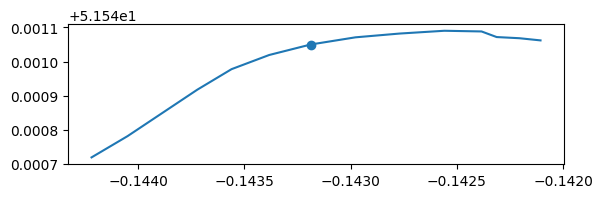

In [12]:
point_2 = Point(-0.1431889, 51.5410498)
lrs_x_coords_2 = wgs_to_lrs(point_2, gdf)
print(lrs_x_coords_2)
plot_wgs(gdf,point_2)

Again this looks about right! The point is about halfway along the line.

### Part two: Answers

POINT(-0.1427707 51.5410819) -> Point(110.5852393 0)

POINT(-0.1431889 51.5410498) -> Point(81.3373429 0)

---



### Part three:

I will make use of shapely.ops nearest_points for this section.

I will do this calculation in crs = EPSG:27700 because this will represent real distances in meters (the effect of the projection on a small scale like this will be very small but I think its still worth coding this way for completeness).

In [13]:
def snap_nearest_point(gdf_wgs, given_point_wkt):
  given_point = gpd.GeoDataFrame(geometry=[given_point_wkt], crs='EPSG:4326').copy()

  given_point_m = given_point.to_crs(crs='EPSG:27700')
  gdf_m = gdf_wgs.to_crs(crs='EPSG:27700')

  # Find the nearest points
  nearest_geom_line, _ = nearest_points(gdf_m['geometry'].iloc[0], given_point_m['geometry'].iloc[0])

  # Convert the nearest point on the LineString to coordinates
  nearest_point_coords_m = gpd.GeoDataFrame(geometry=[Point((nearest_geom_line.x, nearest_geom_line.y))], crs='EPSG:27700').copy()
  nearest_point_coords_wgs = nearest_point_coords_m.to_crs(crs='EPSG:4326')

  # Converting to lrs
  nearest_point_point_lrs = wgs_to_lrs(nearest_point_coords_wgs['geometry'].iloc[0], gdf_wgs)
  nearest_point_coords_lrs = gpd.GeoDataFrame(geometry=[nearest_point_point_lrs])

  return nearest_point_coords_wgs, nearest_point_coords_lrs


def plot_nearest_point_wgs(line_gdf, given_point, nearest_point):
  given_point_wgs = gpd.GeoDataFrame(geometry=[given_point], crs='EPSG:4326')
  geom =  [given_point_wgs['geometry'].iloc[0]] + [nearest_point['geometry'].iloc[0]]
  gdf_points = gpd.GeoDataFrame(geometry=geom, crs = 'EPSG:4326')

  ax = line_gdf.plot(color='blue', linewidth=2)
  gdf_points.plot(ax=ax, color='red', markersize=50)
  ax.set_title('Nearest point on line')
  # ax.set_aspect('equal')
  plt.show()

In [14]:
point_1 = Point(-0.1426069, 51.5411983)
nearest_wgs_1, nearest_lrs_1 = snap_nearest_point(gdf, point_1)
print(f'WGS: {nearest_wgs_1.iloc[0,0]} \nLRS: {nearest_lrs_1.iloc[0,0]}')

WGS: POINT (-0.1425959475001876 51.54108867664946) 
LRS: POINT (122.7306215 0)


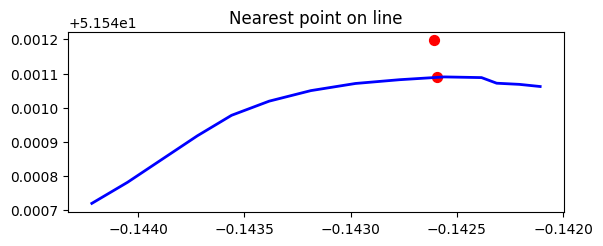

In [15]:
plot_nearest_point_wgs(gdf, point_1, nearest_wgs_1)

In [16]:
point_2 = Point(-0.1434099, 51.5404112)
nearest_wgs_2, nearest_lrs_2 = snap_nearest_point(gdf, point_2)
print(f'WGS: {nearest_wgs_2.iloc[0,0]} \nLRS: {nearest_lrs_2.iloc[0,0]}')

WGS: POINT (-0.1438795644345132 51.54085220713253) 
LRS: POINT (28.1246444 0)


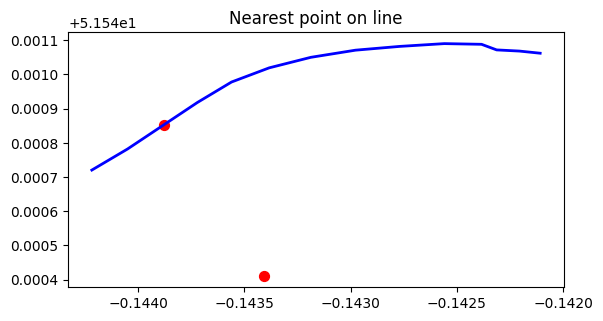

In [17]:
plot_nearest_point_wgs(gdf, point_2, nearest_wgs_2)

In [18]:
point_3 = Point(-0.1478768, 51.5412199)
nearest_wgs_3, nearest_lrs_3 = snap_nearest_point(gdf, point_3)
print(f'WGS: {nearest_wgs_3.iloc[0,0]} \nLRS: {nearest_lrs_3.iloc[0,0]}')

WGS: POINT (-0.1442230874833985 51.540718095420296) 
LRS: POINT (0.0004898 0)


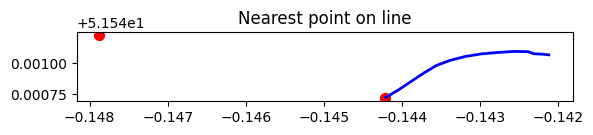

In [19]:
plot_nearest_point_wgs(gdf, point_3, nearest_wgs_3)

Part three: Answers

POINT(-0.1426069 51.5411983) ->

WGS: -0.1425959 51.5410887)

LRS: POINT (122.7306215 0)

<br>

POINT(-0.1434099 51.5404112) ->

WGS: (-0.1438796 51.5408522)

LRS: (28.1246444 0)

<br>

POINT(-0.1478768 51.5412199) ->

WGS: (-0.1442231 51.5407181)

LRS: (0.0004898 0) Essentially the start of the line

---